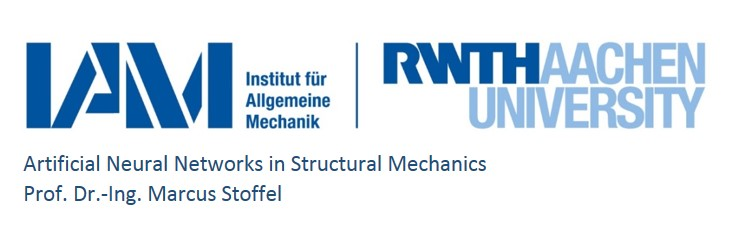

# Exercise 12

# Generative Adversarial Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose ,BatchNormalization, Dense, Dropout, Reshape 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate, LeakyReLU , Flatten
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display
import glob

* Load MNIST data. You can try this code on other datasets like fashion_mnist, CIFAR10, CIFAR100 and so on. Incase of RGB datasets like CIFAR make sure that you either convert the dataset to grayscale or convert the architecture to output 28x28x3

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

* Buffer_size - Defines the number of images that tensorflow.data should keep in its memory buffer and feed in batches.
* Batch_size - Defines the batch size of the training. Generally defined in multiples of 2.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

#### Create input data pipeline

* A tensorflow.data input pipeline facilitates use of huge amounts of data.
* Easy to perform image transformations and augumentations during pre-processing stage.
* Can easily read from different input formats (jpg, png, tif and so on in case of images)

In [ ]:
# Tensorflow data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### Generator

 * Consists of a dense stack in the beginning to map and reshape the input latent vector into a tensor
 * The dense stack is followed by upsampling blocks that deconvolutes the tensor into an image at the end.
 * The output block consists of a tanh activation in this case since we have normalized the dataset between -1 and 1.

In [ ]:
def Generator():
    model = tf.keras.Sequential()
    
    # Dense block ----------------------------
    model.add(Dense(7*7*256, use_bias=False, input_shape=(128,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # Dense block ----------------------------
    
    model.add(Reshape((7, 7, 256)))
    
    # Upsampling block -----------------------
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # Upsampling block -----------------------
    
    # Upsampling block -----------------------
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # Upsampling block -----------------------
    
    # Output layer
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

### Initialize the generator block and check the model summary

In [ ]:
generator = Generator()
generator.summary()

#### Discriminator

 * Consists of a downsample stack which is comprises of a conv2d layer followed by leakyrelu activation layer and a dropout layer to prevent overfitting.
 * Has the architecture of a CNN network.
 * Gives a probability output of whether the given image is real or fake

In [ ]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                              input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

### Initialize the Discriminator block and check the model summary

In [ ]:
discriminator = Discriminator()
discriminator.summary()

### Binary cross entropy

Entropy is a measure of the uncertainty associated with a given distribution.

Here we would like the discriminator to differentiate between real and fake images. Hence we assign

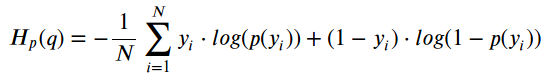

Real image - 1
Fake image - 0

Here, $y_{i}$ is the label (takes the value of 1 for real and 0 for fake images) and $p(y_{i})$ is the probability of the image being real. As you can observe from the formula, for each real image, the term $log(p(y_{i}))$ adds to the loss, and for every fake image, $log(1-p(y_{i}))$ is added to the loss.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    # We want the real loss to be close to one and the fake loss to be close to zero for an accurate prediction.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # we compute the sum of these two losses as total loss of the gan.
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    # We want the generator to be rewarded for generating realisitc output. Hence we want the output of binary
    # cross entropy to be close to 1 for generator loss.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Since GANs take very long time to train, create training checkpoints to restart your training when interrupted.

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100

noise_dim = 128
num_examples_to_generate = 16

# A random tensor named seed to to visualize the output as training progresses
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### TF.FUNCTION

tf.function is a decorator function provided in tf 2.0 that converts regular python code to a callable Tensorflow graph. It compiles the code into a python independent tensorflow graph for better performance. (Converts eager execution to lazy execution ie converts dynamic graphs to static graph which are faster in execution). Static graphs prevent the need of repetitive reinitializing variables during loops.

In [ ]:
@tf.function
def train_step(images):
    
    # Input latent vector for generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # Initialize gradient tapes to calculate and store custom gradients.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      # Obtain fake image from generator
      generated_images = generator(noise, training=True)
      
      # Obtain discriminator outputs for real and fake images.
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      # Calculate the generator loss by passing the disciminator output for fake image.
      gen_loss = generator_loss(fake_output)
      # calculate the discriminator loss for real and fake outputs
      disc_loss = discriminator_loss(real_output, fake_output)
    
    # Gradients are computed using these below lines.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Weights are updated using the adam optimizer.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    
  for epoch in range(epochs):
    # To calculate time for each epoch
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    
    # Display generated images
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)